In [1]:
from __future__ import print_function

import pandas as pd
import numpy as np
import joblib as jl

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, TSNE
from sklearn import metrics
from sklearn.feature_selection import chi2

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

root = 'naive_clf_assessment'

# Load data

In [2]:
labels = pd.read_csv('../../tmp/1_METONLY_vs_METX/matched_CEM_table.csv', header=0).rename({'Unnamed: 0': 'PIN'}, axis=1)[['PIN', 'CLASS']].set_index('PIN')
print(labels.shape)
print(labels.head())

(11744, 1)
         CLASS
PIN           
568483       1
923748       0
2035328      0
2239386      1
2244533      1


In [3]:
data = pd.read_csv('../../tmp/raw_sequences.csv', header=0, index_col=0).loc[labels.index, 'seq']
data.head()

PIN
568483     10990 0 23 1 725 0 10990 0 10990 0 10990 0 109...
923748     66653 0 65070 0 66515 0 10962 0 105 0 56807 2 ...
2035328    66536 0 74995 0 66512 0 66551 0 66608 0 66716 ...
2239386    10991 0 23 3 73928 0 66560 0 66515 0 66551 0 6...
2244533    10990 0 23 2 23 0 10990 0 73928 0 66500 0 6656...
Name: seq, dtype: object

# Check number of features

In [4]:
bow = CountVectorizer(analyzer='word', ngram_range=(1, 1), tokenizer=lambda x: x.split(' '))#, max_features=1000)
tfidf = TfidfTransformer()
xr = tfidf.fit_transform(bow.fit_transform(data))
print(xr.shape)

(11744, 2774)


# Evaluate simple pipeline

In [5]:
max_ngram = 1

def tokenizer(x):
    return x.split(' ')

pipe = Pipeline([
    ('vect', CountVectorizer(analyzer='word', ngram_range=(1, max_ngram),
                             tokenizer=tokenizer)),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(penalty='l1'))
    ])

In [6]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.25)

cv_results_ = cross_validate(pipe, data, labels.values.ravel(), n_jobs=-1,
                             cv=sss, scoring=('accuracy', 'precision',
                                              'recall', 'f1', 'roc_auc'),
                             return_train_score=True
                            )

In [7]:
cv_results = pd.DataFrame(cv_results_).transpose()
cv_results.loc[:, 'MEAN'] = cv_results.mean(axis=1)
cv_results.loc[:, 'STD'] = cv_results.std(axis=1)
out = cv_results[['MEAN', 'STD']]
out

,MEAN,STD
fit_time,2.606839,0.104083
score_time,1.632481,0.041114
test_accuracy,0.741008,0.009771
test_f1,0.718157,0.012560
test_precision,0.787371,0.007935
test_recall,0.660218,0.016379
test_roc_auc,0.809570,0.011701
train_accuracy,0.751431,0.003228
train_f1,0.730659,0.004066
train_precision,0.797256,0.002830


In [8]:
out.to_csv(root+'/{}-GRAM_cv_results.csv'.format(max_ngram))

# Confusion matrix

In [9]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return plt

In [10]:
y = labels.values.ravel()

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5)
tr_idx, ts_idx = next(sss.split(np.empty_like(y), y))


bow = Pipeline([('step1', CountVectorizer(analyzer='word', ngram_range=(1, max_ngram),
                                          tokenizer=tokenizer)),
                ('step2', TfidfTransformer())]
              )
x_train = bow.fit_transform(data.iloc[tr_idx])
x_test = bow.transform(data.iloc[ts_idx])
y_train, y_test = y[tr_idx], y[ts_idx]
print(x_train.shape)

classifier = LogisticRegressionCV(n_jobs=-1)
y_pred = classifier.fit(x_train, y_train).predict(x_test)

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

(5872, 2326)


Test acc: 0.743
Test AUC: 0.743


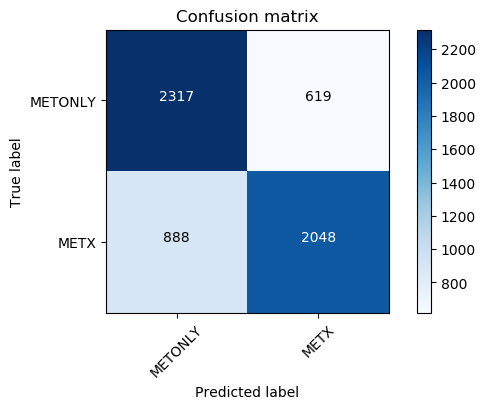

In [11]:
print('Test acc: {:2.3f}'.format(metrics.accuracy_score(y_test, y_pred)))
print('Test AUC: {:2.3f}'.format(metrics.roc_auc_score(y_test, y_pred)))

# Plot non-normalized confusion matrix
plt.figure(dpi=100)
plot_confusion_matrix(cnf_matrix, classes=['METONLY', 'METX'],
                      title='Confusion matrix', cmap=plt.cm.Blues)
plt.savefig(root+'/{}-GRAM_cm.png'.format(max_ngram))

# Learning curves

In [16]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.
    """
    plt.figure(dpi=100)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    
    plt.xlabel("Training examples")
    plt.ylabel("ROC AUC")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc')
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.5,
                     color="C0")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.5, color="C1")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="C0",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'x-', color="C1",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.tight_layout()
    return plt

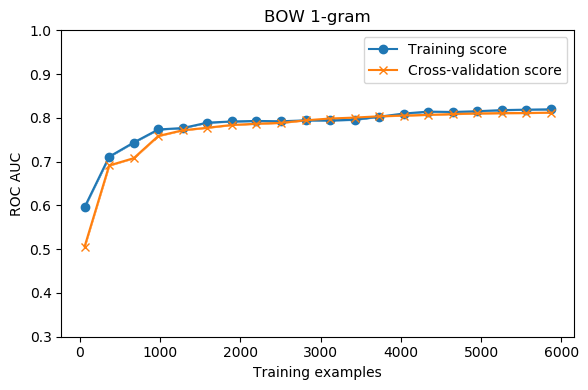

In [17]:
plot_learning_curve(pipe, 'BOW {}-gram'.format(max_ngram),
                    data, labels.values.ravel(), cv=sss, ylim=[0.3, 1],
                    n_jobs=-1, train_sizes=np.linspace(0.01, 1, 20))
plt.savefig(root+'/{}-GRAM_lcurves.png'.format(max_ngram));

# Regularization path

In [18]:
y = labels.values.ravel()

bow = Pipeline([('step1', CountVectorizer(analyzer='word', ngram_range=(1, max_ngram),
                                          tokenizer=tokenizer)),
                ('step2', TfidfTransformer())]
              )
X = bow.fit_transform(data)
print(X.shape)

(11744, 2774)


In [19]:
nC = 100
C_range = np.logspace(-2, 0, nC)

def fitmodel(C):
    return LogisticRegression(penalty='l1', C=C).fit(X, y).coef_

coefs = jl.Parallel(n_jobs=nC)(jl.delayed(fitmodel)(C) for C in C_range)
coefs = np.array(coefs)[:,0,:].T

/home/samu/miniconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


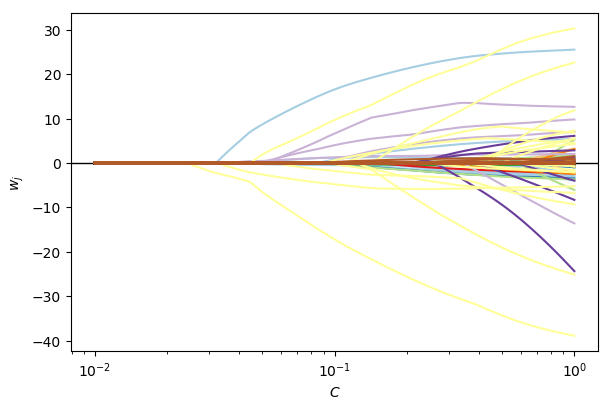

In [20]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)

colormap = plt.cm.Paired
ax.set_color_cycle([colormap(i) for i in np.linspace(0, 1, coefs.shape[0])])
plt.axhline(color='k', linewidth=1, linestyle='solid') # xaxis

for i, _coef in enumerate(coefs):
    ax.semilogx(C_range, _coef, label=bow.steps[0][1].get_feature_names()[i])
    
# lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.xlabel(r'$C$')
plt.ylabel(r'$w_j$')
plt.savefig(root+'/{}-GRAM_regpath.png'.format(max_ngram), bbox_inches='tight');
#  bbox_extra_artists=(lgd,),

In [25]:
K = 25
first_K_nonzeros = []
for coef in coefs.T:
    nonzeros = np.nonzero(coef)[0]
    for i in nonzeros:
        if (i not in set(first_K_nonzeros)) and (len(first_K_nonzeros) <= K):
            first_K_nonzeros.append(i)
print(np.array(bow.steps[0][1].get_feature_names())[first_K_nonzeros])

[u'74995' u'0' u'10993' u'732' u'65120' u'10990' u'10991' u'73928'
 u'66551' u'66515' u'35' u'74999' u'10996' u'2' u'3' u'85733' u'66560'
 u'85022' u'74998' u'10960' u'725' u'74993' u'73938' u'42738' u'10997'
 u'24']


# Linear feature weight

In [23]:
pipe = Pipeline([
    ('vect',  CountVectorizer(analyzer='word', ngram_range=(1, max_ngram),
                                          tokenizer=tokenizer)),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression())
    ])

pipe.fit(data, labels.values.ravel())

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        str...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

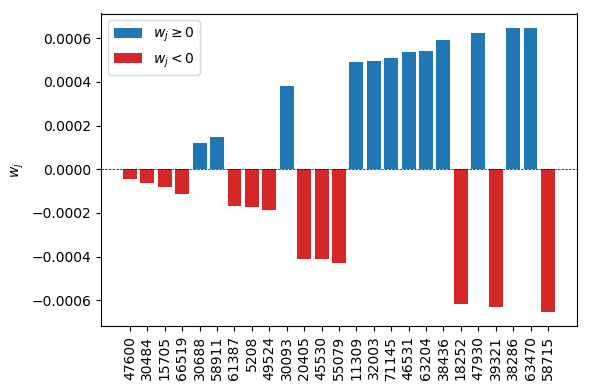

In [24]:
K = 25

plt.figure(dpi=100)

coef = pipe.steps[2][1].coef_[0]
idx = np.argsort(np.abs(coef))[:K]
coef = coef[idx]
feature_map = np.array(pipe.steps[0][1].get_feature_names())[idx]
d = len(coef)

xaxis = np.arange(d)
pos_idx = np.where(coef >= 0)[0]
neg_idx = np.where(coef < 0)[0]
plt.bar(xaxis[pos_idx], coef[pos_idx], label=r'$w_j \geq 0$', color='C0') # positive coefs
plt.bar(xaxis[neg_idx], coef[neg_idx], label=r'$w_j < 0$', color='C3') # negative coefs
plt.axhline(color='k', linewidth=0.5, linestyle='dashed')
plt.ylabel(r'$w_j$')
plt.xticks(xaxis, [feature_map[i].upper() for i in range(d)], rotation=90)
plt.legend(loc=2)
plt.tight_layout()
plt.savefig(root+'/{}-GRAM_weights.png'.format(max_ngram), bbox_inches='tight');

# Data viz

In [26]:
pipe = Pipeline([
    ('vect',  CountVectorizer(analyzer='word', ngram_range=(1, max_ngram),
                                          tokenizer=tokenizer)),
    ('tfidf', TfidfTransformer()),
    ('s2d', FunctionTransformer(lambda sp: sp.toarray(), validate=False)),
    ('pp', Normalizer()),
#     ('dr0', PCA(n_components=50)),
    ('dr1', Isomap(n_components=3))
    ])

x_r = pipe.fit_transform(data)

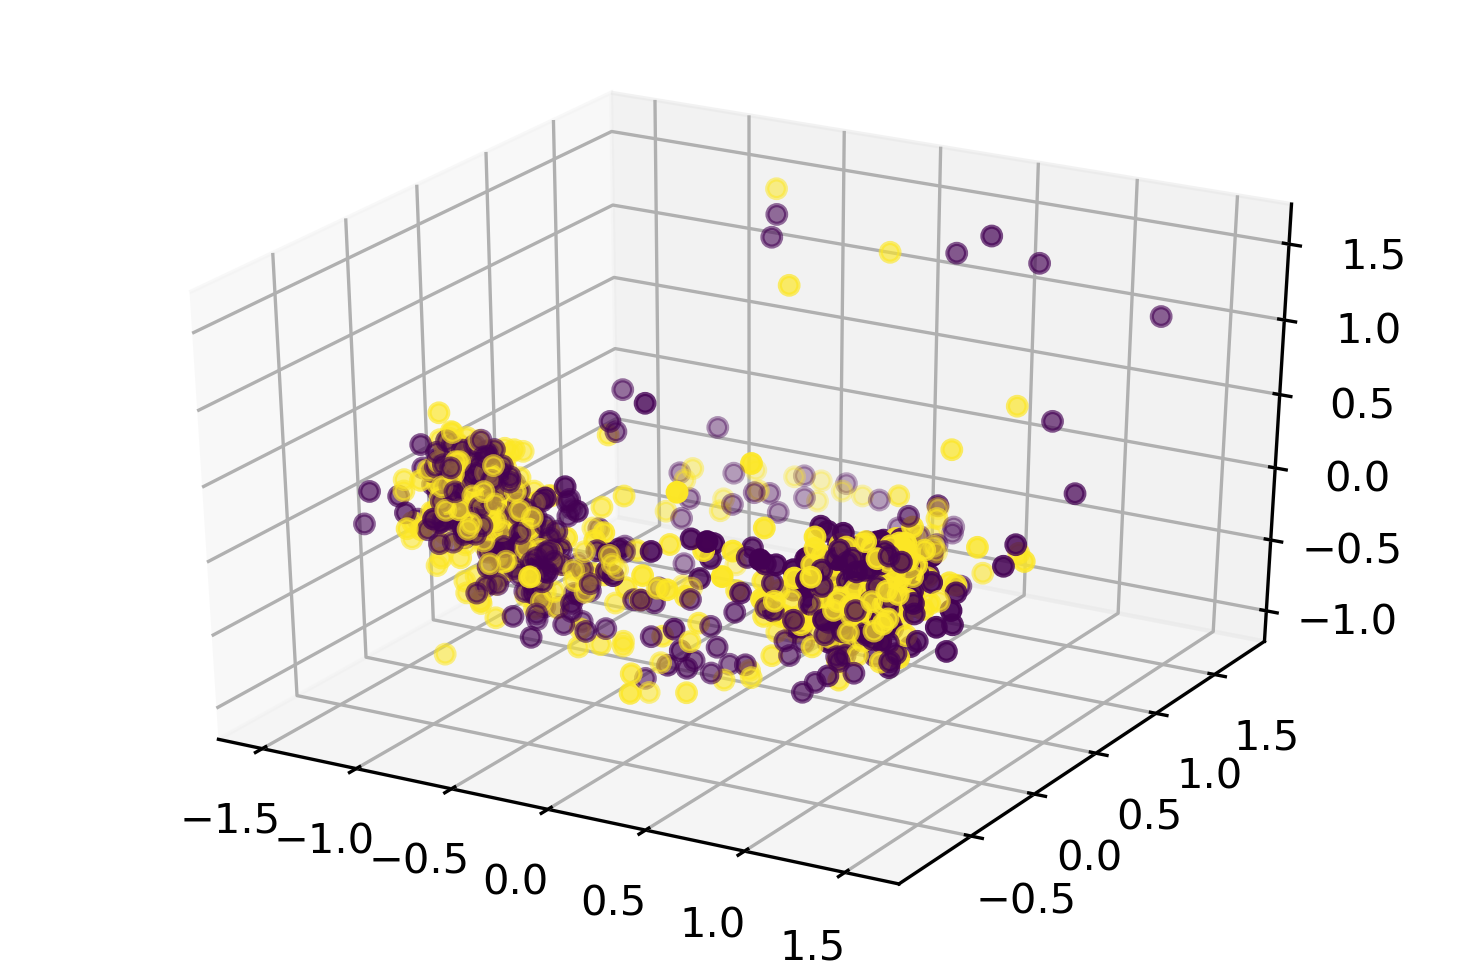

In [34]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(111, projection='3d')

idx = np.arange(x_r.shape[0])
np.random.shuffle(idx)
idx = idx[:1000]

ax.scatter(x_r[idx, 0], x_r[idx, 1], x_r[idx, 2], c=y[idx])
plt.savefig(root+'/{}-GRAM_scatter.png'.format(max_ngram), bbox_inches='tight');

# Tidy Features

In [28]:
y = labels.values.ravel()

pipe = Pipeline([
    ('vect',  CountVectorizer(analyzer='word', ngram_range=(1, max_ngram), tokenizer=tokenizer)),
    ('tfidf', TfidfTransformer()),
    ('s2d', FunctionTransformer(lambda sp: sp.toarray(), validate=False)),
    ('pp', Normalizer())
    ])

X = pipe.fit_transform(data)
feature_map = np.array(pipe.steps[0][1].get_feature_names())

In [29]:
df = pd.DataFrame(X, index=labels.index,
                  columns=[feature_map[i] for i in range(X.shape[1])])
df.loc[:, 'class'] = labels['CLASS']
df.head()

,0,1,104,105,106,107,108,10804,10809,10900,...,903,91,92,93,95,96,97,98,99,class
PIN,,,,,,,,,,,,,,,,,,,,,
568483,0.749303,0.054053,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
923748,0.844759,0.100549,0.020885,0.082968,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2035328,0.921633,0.070950,0.063662,0.123976,0.0,0.0,0.0,0.0,0.0,0.012422,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2239386,0.870125,0.080474,0.009257,0.064901,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2244533,0.818075,0.042669,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.008301,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


# Feature selection
Using simple filter methods.

In [30]:
stat, pval = chi2(df[df.columns.drop('class')], df['class'])
chi2_test = pd.DataFrame(data=np.vstack((stat, pval)).T, index=df.columns.drop('class'), columns=['Stat', 'p-value'])
chi2_test.sort_values(by='p-value', inplace=True)
chi2_test.iloc[:15]

,Stat,p-value
66515,40.191963,2.301933e-10
10993,35.479455,2.577549e-09
725,26.058595,3.312110e-07
732,19.913969,8.100628e-06
10996,17.562002,2.780899e-05
727,15.576821,7.921981e-05
74995,13.970577,1.856940e-04
42738,10.813631,1.007555e-03
66833,10.746695,1.044657e-03
50124,8.916711,2.825730e-03


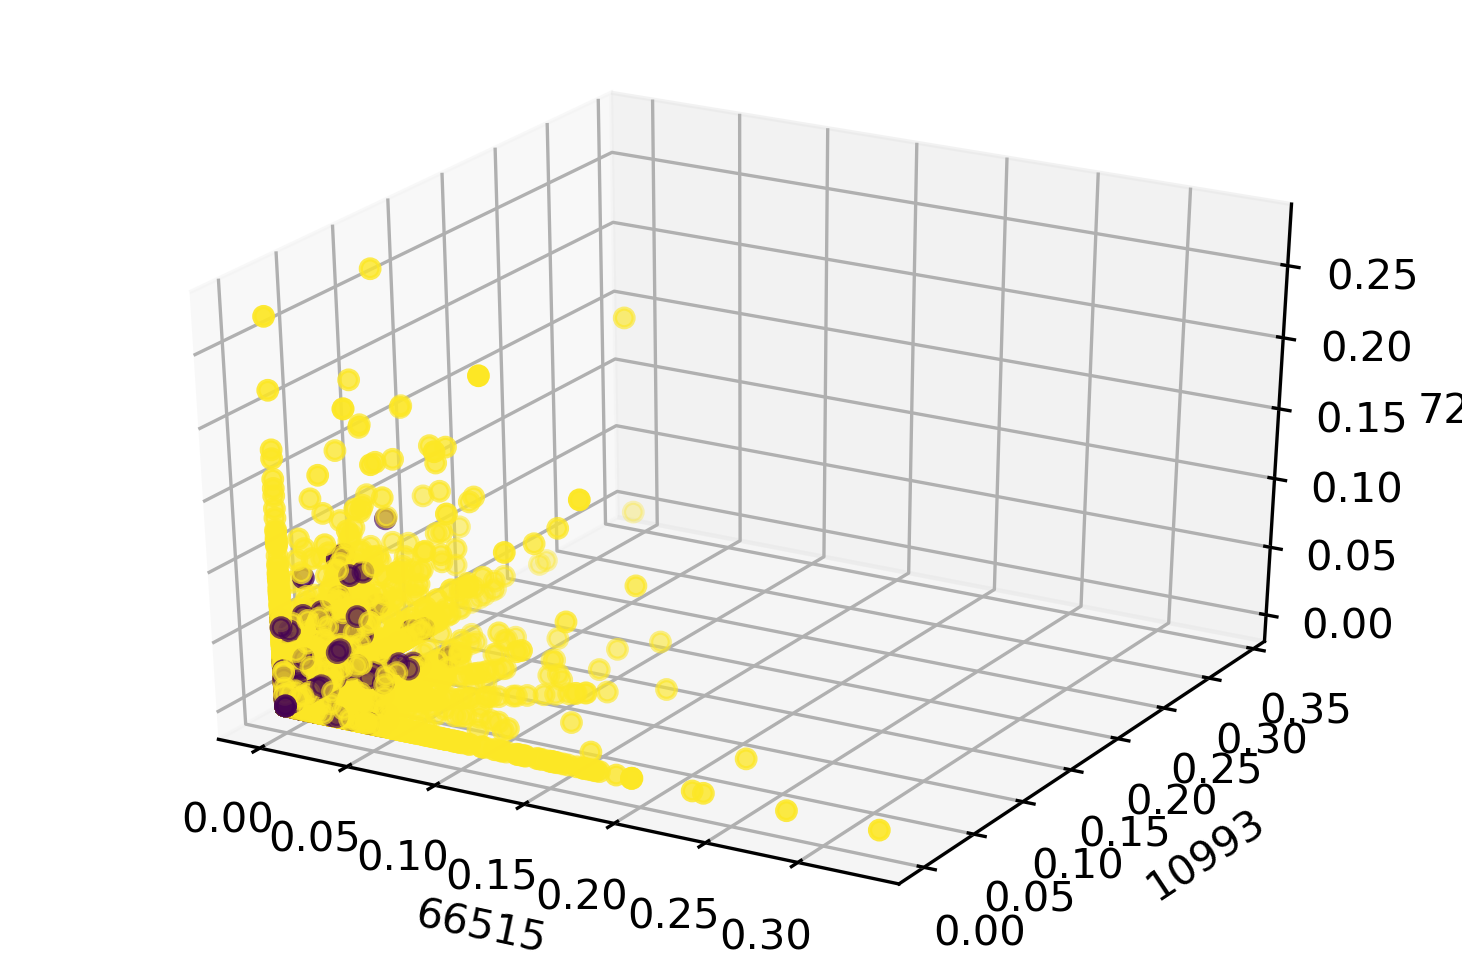

In [31]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df[chi2_test.index[0]],
           df[chi2_test.index[1]],
           df[chi2_test.index[2]], c=df['class'])

ax.set_xlabel(chi2_test.index[0])
ax.set_ylabel(chi2_test.index[1])
ax.set_zlabel(chi2_test.index[2]);